<h1 style="text-align:center">Mass-Spring-Pendulum Example</h1>
<h3 style="text-align:center"> MCHE 513: Intermediate Dynamics</h3> 
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>

<p style = "text-align: center;">
	<img src="http://shared.crawlab.org/Spring_mass_pendulum.png" alt="A Mass-Spring-Pendulum System" width=40%><br>
    <strong> Figure 1: A Mass-Spring-Pendulum System</strong>
</p><br>

This notebook demonstrates the analysis of the system shown in Figure 1. Mass $m_1$ is attached to ground via a spring and constrained to move horizontally. Its horizontal motion from equilibrium is described by $x$. Mass $m_2$ is suspended from the center of $m_1$ via a massless, inextensible, inflexible cable of length $l$. The angle of this cable from horizontal is described by $\theta$. The linearized equations of motion for the system are:

$ \quad \left(m_1 + m_2\right) \ddot{x} - m_2 l \ddot{\theta} + k x = f $

$ \quad -m_2 l \ddot{x} + m_2 l^2 \ddot{\theta} + m_2 g l \theta = 0 $

We could also write this equation in matrix form:

$ \quad \begin{bmatrix}m_1 + m_2 & -m_2 l \\ -m_2 l & \hphantom{-}m_2 l^2\end{bmatrix}\begin{bmatrix}\ddot{x} \\ \ddot{\theta}\end{bmatrix} + \begin{bmatrix}k & 0 \\ 0 & m_2 g l\end{bmatrix}\begin{bmatrix}x \\ \theta\end{bmatrix} = \begin{bmatrix}f \\ 0\end{bmatrix}$

We'll use the [Sympy](http://sympy.org) tools to verify these equations of motion, then [NumPy](http://numpy.org) and [SciPy](http://scipy.org) to simulate the response of this system.

In [1]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from sympy.physics.mechanics import Particle, Point, ReferenceFrame

# initiate better printing of SymPy results
sympy.init_printing()

In [2]:
# Define the genearlized coordinate
x, theta, f = dynamicsymbols('x theta f')

# Also define the first derivative
x_dot, theta_dot = dynamicsymbols('x theta', 1)

# Define the symbols for the other paramters
m1, m2, k, g, l, t = sympy.symbols('m_1, m_2, k, g, l, t')

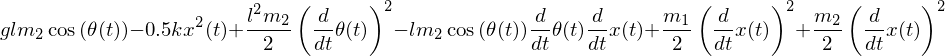

In [6]:
# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define a body-fixed frame along the pendulum, with y aligned from m to the pin
A = N.orientnew('A', 'Axis', [-theta, N.z])

# Define the trolley point and its velocity
T = Point('T')
T.set_vel(N, x_dot * N.x)

# Treat the trolley as a particle
mtr = Particle('mtr', T, m1)

# Define the payload point and set its velocity
P = Point('P')
P.set_vel(N, x_dot * N.x - l * theta_dot * A.x)

# The payload is a particle (a point mass)
mp = Particle('mp', P, m2)

# Define the potential energy of the payload 
mp.potential_energy = -m2 * g * l * sympy.cos(theta) # gravity
mtr.potential_energy = 1 / 2 * k * x**2              # spring potential

# Set up the force list - each item follows the form:
#    (the location where the force is applied, its magnitude and direction)
forces = [(T, f * N.x)]

# Form the Lagrangian, then simplify and print
L = Lagrangian(N, mtr, mp)
L.simplify()

In [7]:
# This creates a LagrangesMethod class instance that will allow us to form the equations of motion, etc
LM = LagrangesMethod(L, [x, theta], forcelist = forces, frame = N)

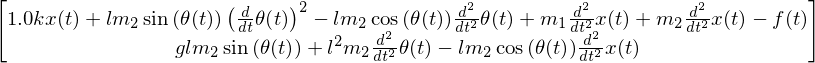

In [8]:
LM.form_lagranges_equations()

The <tt>LagrangesMethod</tt> class gives us lots of information about the system. For example, we can output the mass/inertia matrix and the forcing terms. Note that the forcing terms include what might be conservative forces and would therefore normally appear in a stiffness matrix.

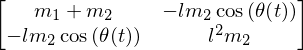

In [9]:
# Output the inertia/mass matrix of the system
LM.mass_matrix

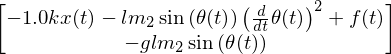

In [10]:
# Output the forcing terms of the system
LM.forcing

We can also use builtin functions to write the sytsem as a set of first order ODEs, suitable for simluation.

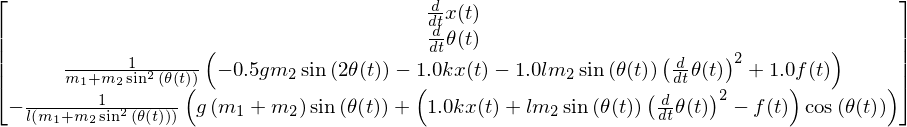

In [11]:
# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

# Simplify the results
lrhs.simplify()

# Output the result
lrhs

We can also linearize these equations with builtin SymPy methods. Let's do so about the $x = \dot{x} = \theta = \dot{\theta} = 0$ operating point. The resulting equations returned are a system of first order ODEs in state-space form:

$$ \dot{x} = Ax + Bu $$

See the [SymPy Documentation](http://docs.sympy.org/0.7.6/modules/physics/mechanics/linearize.html#linearizing-lagrange-s-equations) for much more information.

In [12]:
# Define the point to linearize around
operating_point = {x: 0.0, x_dot: 0.0, theta: 0.0, theta_dot: 0.0}

# Make the call to the linearizer
A, B, inp_vec = LM.linearize([x, theta], [x_dot, theta_dot],
                             op_point = operating_point, 
                             A_and_B = True)

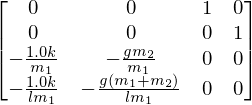

In [13]:
# simplify and print out the A matrix
A.simplify()
A

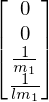

In [14]:
# simplify and print out the B matrix
B.simplify()
B

## Checking the Result
These equations match the linearized equations of motion from the top of this notebook, if they are written as a system of first order ODEs, rather than two second-order ODEs.
To begin, let's define a state vector $\mathbf{w} = \left[x \quad \theta \quad \dot{x} \quad \dot{\theta}\right]^T $

As mentioned above, we'll most often see the state space form writen as:

$ \quad \dot{x} = Ax + Bu $

where $x$ is the state vector, $A$ is the state transition matrix, $B$ is the input matrix, and $u$ is the input. We'll use $\mathbf{w}$ here and in the code to avoid confusion with our state $x$, the position of $m_1$.

To begin, let's write the two equations of motion as:

$ \quad \ddot{x} = \frac{1}{m_1 + m_2} \left(m_2 l \ddot{\theta} - k x + f \right)$

$ \quad  \ddot{\theta}= \frac{1}{m_2 l^2} \left(m_2 l \ddot{x} - m_2 g l \theta\right) = \frac{1}{l}\ddot{x} - \frac{g}{l}\theta   $

After some algebra and using the state vector defined above, we can write our equations of motion as:

$$ \dot{\mathbf{w}} = \begin{bmatrix}0 & 0 & 1 & 0\\ 0 & 0 & 0 & 1 \\ -\frac{k}{m_1} & -\frac{m_2}{m_1}g & 0 & 0 \\  -\frac{k}{m_1} & -\left(\frac{m_1 + m_2}{m_1}\right)\frac{g}{l} & 0 & 0 \end{bmatrix}\mathbf{w} + \begin{bmatrix}0 \\ 0 \\ \frac{1}{m_1}  \\ \frac{1}{m_1 l} \end{bmatrix} f $$


Now, we have the option of automating the creation of the functions necessary for use in the ODE solver, like we've done in [some other notebooks](http://nbviewer.ipython.org/github/DocVaughan/MCHE513---Intermediate-Dynamics/blob/master/Planar%20Crane%20with%20SymPy.ipynb). Here, let's manually generate the necessary functions to examine that case.

In [15]:
# import NumPy with namespace np
import numpy as np

# import the ode ODE solver
from scipy.integrate import odeint

# import the plotting functions from matplotlib
import matplotlib.pyplot as plt

# set up the notebook to display the plots inline
%matplotlib inline

In [16]:
# Define the system parameters
m1 = 10.0            # Trolley mass (kg)
m2 = 1.0             # Payload mass (kg)
g = 9.81             # Gravity (m/s^2)
k = 4 * np.pi**2     # Spring constant (N/m)
l = 2.0              # Cable length (m)

To use ```scipy.intergrate.odeint``` we need to define a funciton that represents the system of first order differential equations we want to solve. Here, that is simply the system of equations of motion. The ```odeint``` funciton requires the the arguments of this function be ```w, t, p```, where ```w``` is the vector of states, ```t``` is the time, and ```p``` is a list of other parameters, as necessary. The function should returnn the system as a list.

We'll also define the forcing function, with arguments following the order of those requried by ```odeint```.

In [17]:
# Define the system as a series of 1st order ODES (beginnings of state-space form)
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x, theta, x_dot, theta_dot]
        t :  time
        p :  vector of the parameters:
                  p = [m1, m2, k, l, g, wf]
    
    Returns:
        sysODE : An list representing the system of equations of motion as 1st order ODEs
    """
    x, theta, x_dot,  theta_dot = w
    m1, m2, k, l, g, wf = p

    # Create sysODE = (x', theta', x_dot', theta_dot'):
    sysODE = [x_dot,
              theta_dot,
              -k/m1 * x - m2/m1 * g * theta + f(t,p)/m1,
              -k/(m1 * l) * x - (m1 + m2)/m1 * g/l * theta + f(t, p)/(m1 * l)]
    
    return sysODE



# Define the forcing function
def f(t, p):
    """ 
    Defines the forcing function
    
    Arguments:
        t : time
        p :  vector of the parameters:
             p = [m1, m2, k, l, g, wf]
    
    Returns:
        f : forcing function at current timestep
    """
    
    m1, m2, k, l, g, wf = p
    
    # Uncomment below for no force input - use for initial condition response
    #f = 0.0 
    
    # Uncomment below for sinusoidal forcing input at frequency wf rad/s
    f = np.sin(wf * t)
    
    return f

In [18]:
# Set up simulation parameters 

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 25.0
numpoints = 2501

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0, stoptime, numpoints)

# Initial conditions
x_init = 0.0                        # initial position
x_dot_init = 0.0                    # initial velocity
theta_init = 0.0                    # initial angle
theta_dot_init = 0.0                # initial angular velocity

wf = np.sqrt(k / m1)                # forcing function frequency

# Pack the parameters and initial conditions into arrays 
p = [m1, m2, k, l, g, wf]
x0 = [x_init, theta_init, x_dot_init, theta_dot_init]

In [19]:
# Call the ODE solver.
resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

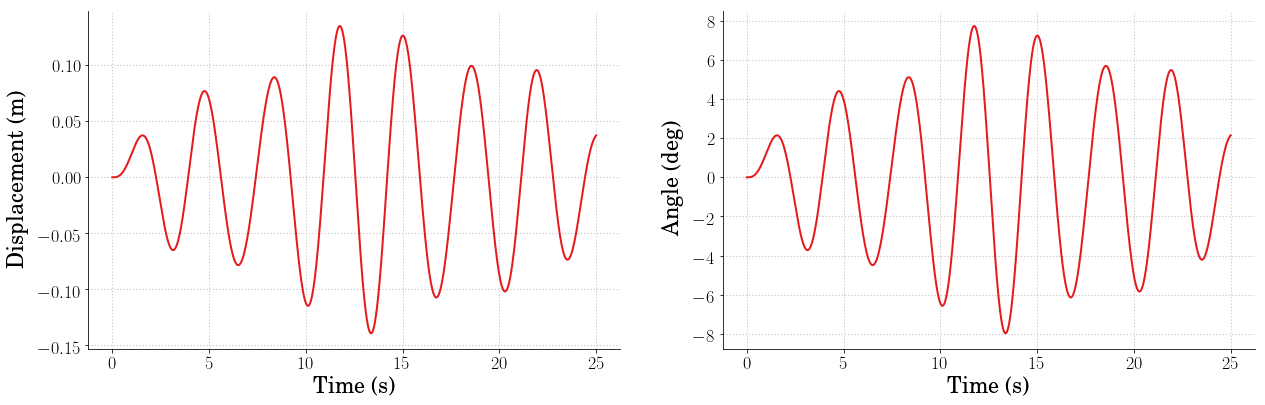

In [20]:
# Let's plot the trolly position and cable angle as subplots, to make it easier to compare

# Make the figure pretty, then plot the results
#   "pretty" parameters selected based on pdf output, not screen output
#   Many of these setting could also be made default by the .matplotlibrc file
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

plt.subplots_adjust(bottom=0.12,left=0.17,top=0.96,right=0.96)
plt.setp(ax1.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax1.get_xmajorticklabels(),family='serif',fontsize=18)
plt.setp(ax2.get_ymajorticklabels(),family='serif',fontsize=18)
plt.setp(ax2.get_xmajorticklabels(),family='serif',fontsize=18)

ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.grid(True,linestyle=':',color='0.75')
ax1.set_axisbelow(True)

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.grid(True,linestyle=':',color='0.75')
ax2.set_axisbelow(True)


# Trolley Position plot
ax1.set_xlabel(r'Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
ax1.set_ylabel(r'Displacement (m)',family='serif',fontsize=22,weight='bold',labelpad=10)
ax1.plot(t, resp[:,0], linewidth=2)


# Cable Angle plot 
ax2.set_xlabel(r'Time (s)',family='serif',fontsize=22,weight='bold',labelpad=5)
ax2.set_ylabel(r'Angle (deg)', family='serif', fontsize=22, weight='bold',labelpad=10)
ax2.plot(t, resp[:,0] * 180/np.pi, linewidth=2)


# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# If you want to save the figure, uncomment the commands below. 
# The figure will be saved in the same directory as your IPython notebook.
# Save the figure as a high-res pdf in the current folder
# savefig('MassSpringPend_Response.pdf', dpi=300)

fig.set_size_inches(18,6) # Resize the figure for better display in the notebook

<hr style="border: 0px;
        height: 1px;
        text-align: center;
        background: #333;
        background-image: -webkit-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:    -moz-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:     -ms-linear-gradient(left, #ccc, #333, #ccc); 
        background-image:      -o-linear-gradient(left, #ccc, #333, #ccc);">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [21]:
# This cell will just improve the styling of the notebook
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))